Rolling Forecast (add non-damped): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]


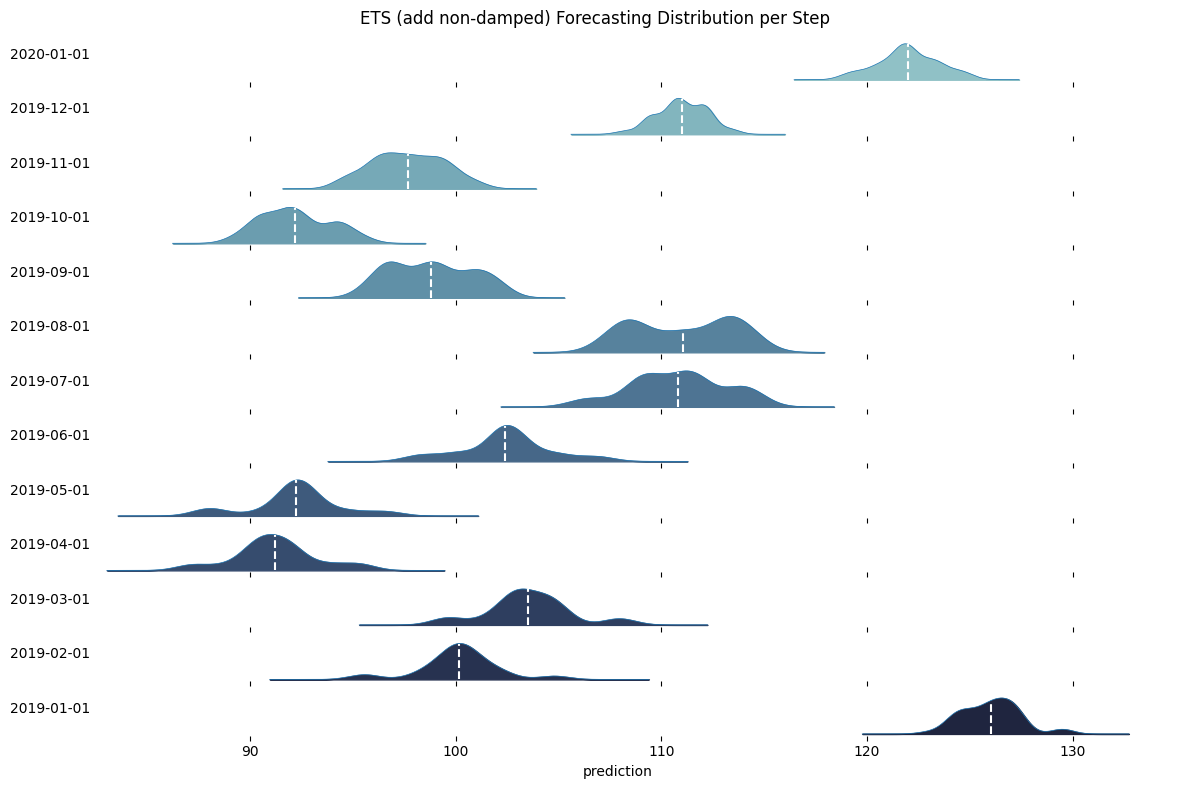

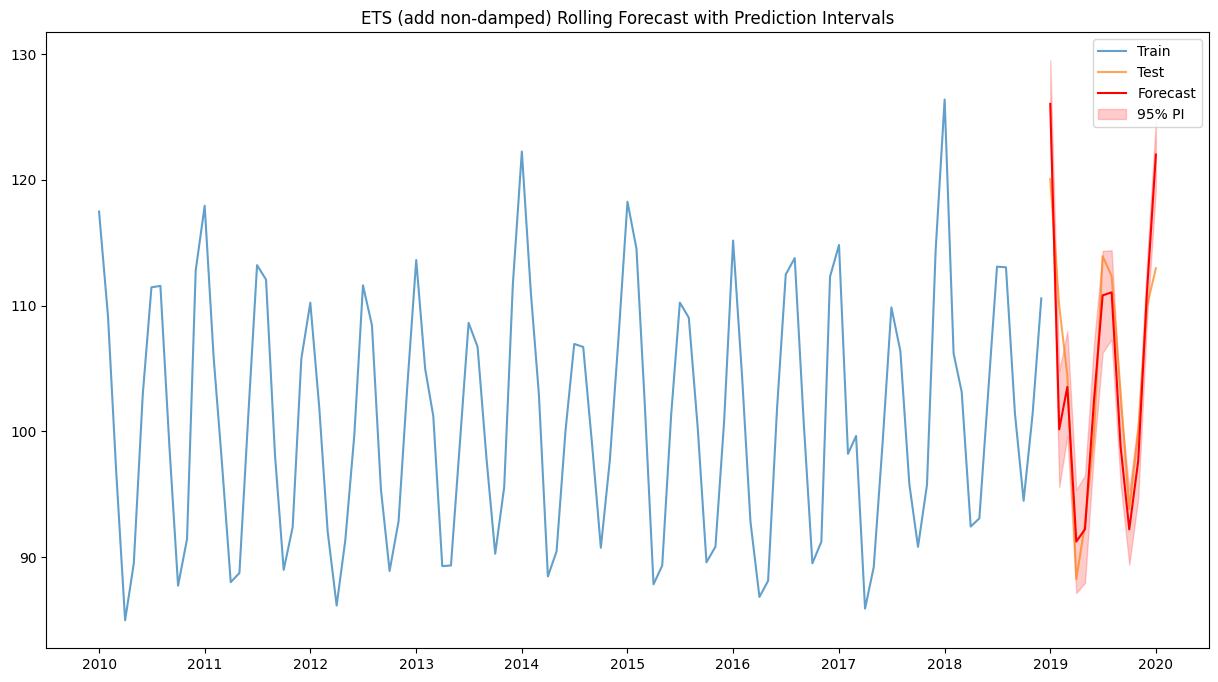

CRPS Score for add non-damped model: 4.898536929685561


Rolling Forecast (add damped): 100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


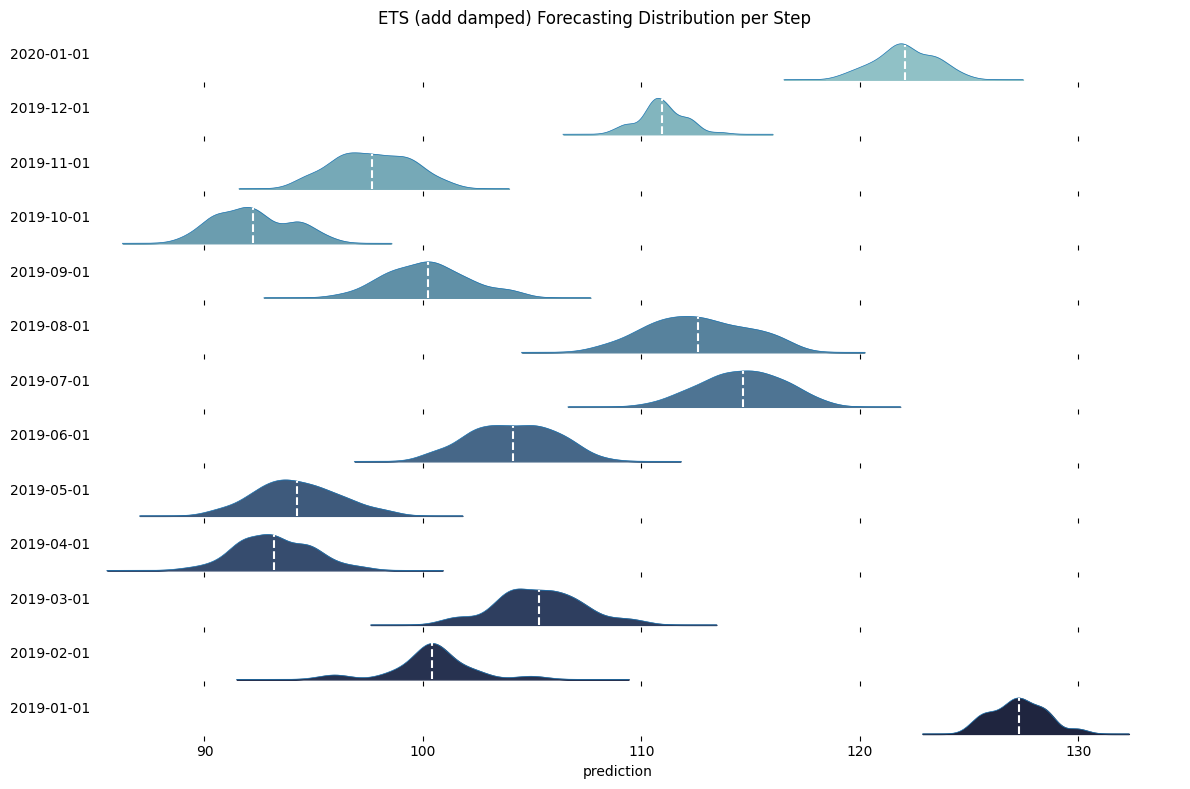

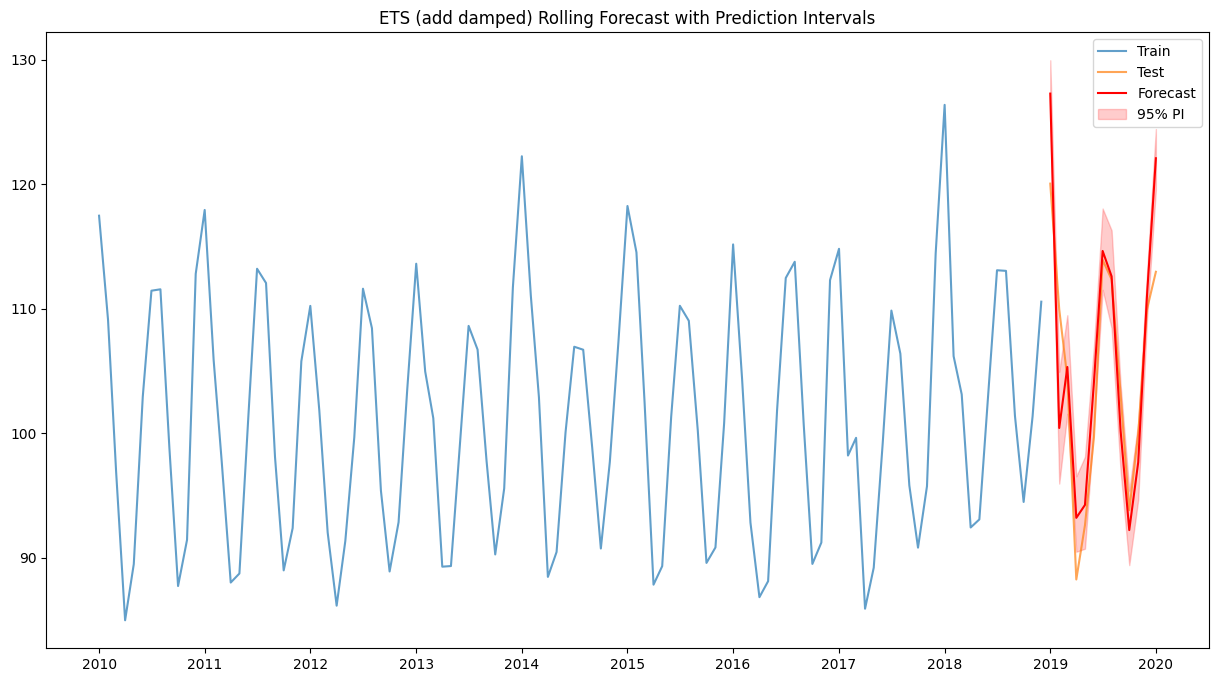

CRPS Score for add damped model: 4.85743643732161


Rolling Forecast (mul non-damped): 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


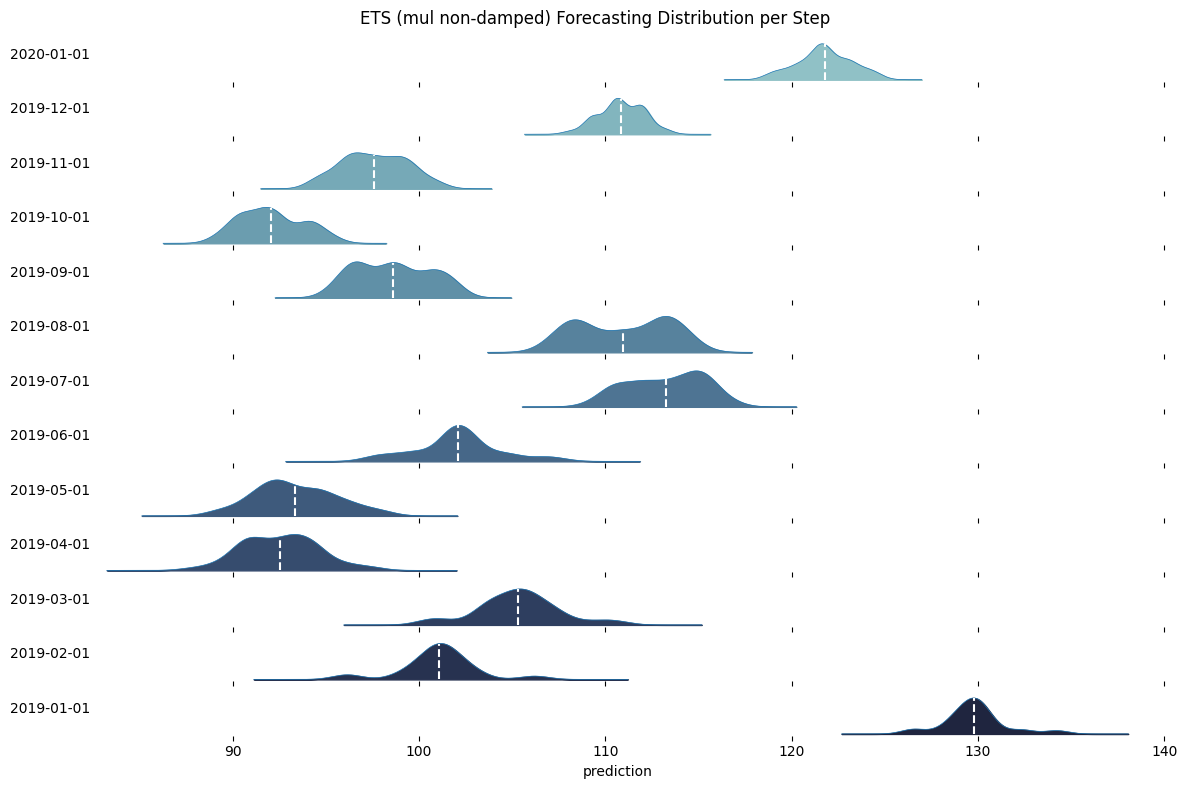

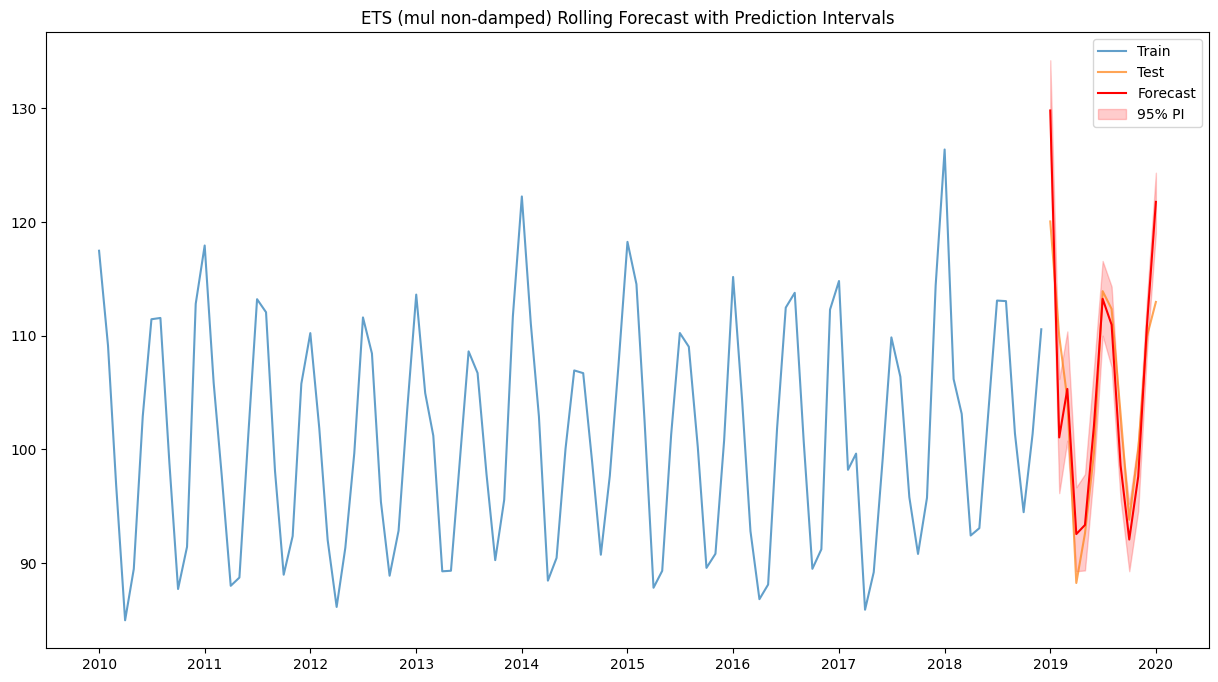

CRPS Score for mul non-damped model: 4.863800752230363
  Family           Model      CRPS
0    ETS      Add Damped  4.857436
1    ETS  Mul Non-Damped  4.863801
2    ETS  Add Non-Damped  4.898537


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Optional, Any
from tqdm import tqdm
import scoringrules as sr

warnings.filterwarnings('ignore')

def fit_ets_model(train_data, model_type='add', damping=False):
    if model_type == 'add':
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12, damped_trend=damping, freq='MS')
    elif model_type == 'mul':
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12, damped_trend=False, freq='MS')
    else:
        raise ValueError("model_type must be either 'add' or 'mul'")
    return model.fit()

def predict_bootstrapping(model, train_data, steps=1, n_boot=500, random_state=123):
    predictions = model.forecast(steps=steps)
    residuals = model.resid
    
    boot_predictions = np.full((steps, n_boot), np.nan)
    rng = np.random.default_rng(seed=random_state)
    
    for i in range(n_boot):
        sample_residuals = rng.choice(residuals, size=steps, replace=True)
        boot_predictions[:, i] = predictions + sample_residuals
    
    return pd.DataFrame(boot_predictions, columns=[f"pred_boot_{i}" for i in range(n_boot)],
                        index=pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='MS'))

def rolling_forecast_with_bootstrapping(train, test, window_size=24, n_boot=500, model_type='add', damping=False):
    all_bootstrap_predictions = []
    
    for i in tqdm(range(len(test)), desc=f"Rolling Forecast ({model_type} {'damped' if damping else 'non-damped'})"):
        train_window = pd.concat([train, test.iloc[:i]])
        model = fit_ets_model(train_window.iloc[-window_size:], model_type=model_type, damping=damping)
        bootstrap_predictions = predict_bootstrapping(model, train_window.iloc[-window_size:], steps=1, n_boot=n_boot)
        all_bootstrap_predictions.append(bootstrap_predictions)
    
    return pd.concat(all_bootstrap_predictions)

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame, model_type: str, damping: bool,
                                 bw_method: Optional[Any] = None, **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    model_title = f"ETS ({model_type} {'damped' if damping else 'non-damped'}) Forecasting Distribution per Step"
    fig.suptitle(model_title)
    return fig

def plot_forecast_with_pi(train, test, forecasts, lower_pi, upper_pi, model_type, damping):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Train', alpha=0.7)
    plt.plot(test.index, test, label='Test', alpha=0.7)
    plt.plot(forecasts.index, forecasts, label='Forecast', color='red')
    plt.fill_between(forecasts.index, lower_pi, upper_pi, color='red', alpha=0.2, label='95% PI')
    plt.title(f'ETS ({model_type} {"damped" if damping else "non-damped"}) Rolling Forecast with Prediction Intervals')
    plt.legend()
    plt.savefig(f"forecast_{model_type}_{'damped' if damping else 'non_damped'}.png")
    plt.show()

# Load and prepare the data
data = pd.read_csv('../../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

# Function to calculate CRPS
def calculate_crps(observations, forecast_ensemble):
    crps_values = []
    for i in range(len(observations)):
        obs = np.array([observations[i]])
        fct = forecast_ensemble.iloc[i].values
        crps = sr.crps_ensemble(obs, fct)
        crps_values.append(crps)
    return np.mean(crps_values)

# Perform rolling forecast with bootstrapping for both 'add' and 'mul' models with and without damping
model_types = ['add', 'mul']
damping_options = [False, True]
results = []

for model_type in model_types:
    for damping in damping_options:
        if model_type == 'mul' and damping:
            continue  # Skip multiplicative damped model

        # Perform rolling forecast with bootstrapping
        bootstrap_predictions = rolling_forecast_with_bootstrapping(train['IPG2211A2N'], test['IPG2211A2N'], window_size=24, n_boot=100, model_type=model_type, damping=damping)
        
        # Plot the prediction distributions
        fig = plot_prediction_distribution(bootstrap_predictions, model_type, damping, figsize=(12, 8))
        plt.tight_layout()
        fig.savefig(f"distribution_{model_type}_{'damped' if damping else 'non_damped'}.png")
        plt.show()
        
        # Calculate forecasts and prediction intervals
        forecasts = bootstrap_predictions.mean(axis=1)
        lower_pi = bootstrap_predictions.quantile(0.025, axis=1)
        upper_pi = bootstrap_predictions.quantile(0.975, axis=1)
        
        # Plot the forecast with prediction intervals
        plot_forecast_with_pi(train['IPG2211A2N'], test['IPG2211A2N'], forecasts, lower_pi, upper_pi, model_type, damping)
        
        # Calculate CRPS for the bootstrap predictions
        observed_values = test['IPG2211A2N'].values
        forecast_ensemble = bootstrap_predictions.T
        crps_score = calculate_crps(observed_values, forecast_ensemble)
        print(f"CRPS Score for {model_type} {'damped' if damping else 'non-damped'} model: {crps_score}")
        
        # Append the results to the final table
        results.append(('ETS', f"{model_type.capitalize()} {'Damped' if damping else 'Non-Damped'}", crps_score))

# Create a table with the results
results_df = pd.DataFrame(results, columns=['Family', 'Model', 'CRPS'])

# Order the table by CRPS descending
results_df = results_df.sort_values(by='CRPS').reset_index(drop=True)

# Display the results table
print(results_df)
